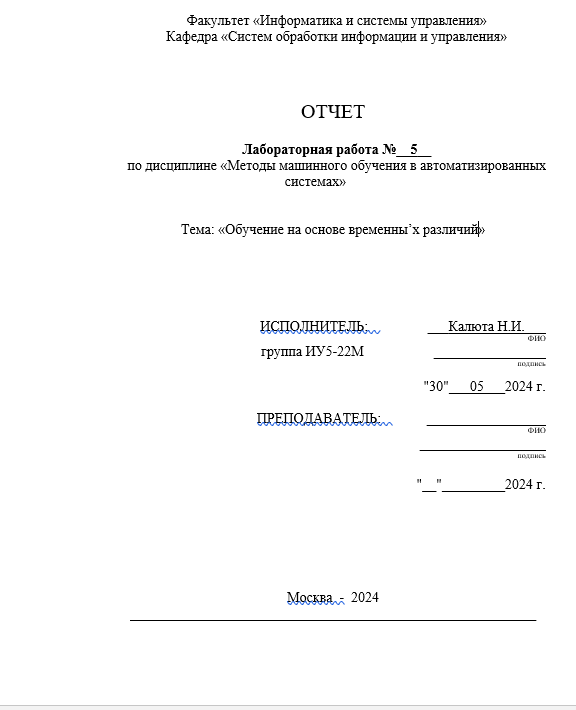

###**Цель лабораторной работы:**
Ознакомление с базовыми методами обучения с подкреплением на основе временных различий.

###**Задание:**

На основе рассмотренного на лекции примера реализуйте следующие алгоритмы:

* SARSA
* Q-обучение
* Двойное Q-обучение

Для любой среды обучения с подкреплением (кроме рассмотренной на лекции среды Toy Text / Frozen Lake) из библиотеки Gym (или аналогичной библиотеки).

# Ход работы

## Установка зависимостей

Установка необходимых библиотек и зависимостей для работы с Atari-играми

In [ ]:
#remove " > /dev/null 2>&1" to see what is going on under the hood
!apt-get update > /dev/null 2>&1
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
!apt-get install cmake > /dev/null 2>&1
!pip install --upgrade setuptools 2>&1
!pip install ez_setup > /dev/null 2>&1

!apt-get update > /dev/null 2>&1
!apt-get install cmake > /dev/null 2>&1
!pip install --upgrade setuptools 2>&1
!pip install ez_setup > /dev/null 2>&1

!pip install swig==4.1.1
!pip install Box2D==2.3.2
!pip install box2d-kengz==2.3.3
!pip install pygame==2.2.0
!pip install ale_py==0.8.1
!pip install pyglet==1.5.11


!pip install -U colabgymrender
!pip install imageio==2.4.1
!pip install --upgrade AutoROM
!AutoROM --accept-license
!pip install gymnasium[atari]==0.28.1

!wget http://www.atarimania.com/roms/Roms.rar
!unrar x -o+ /content/Roms.rar >/dev/nul
!python -m atari_py.import_roms /content/ROMS >/dev/nul

!pip install pyvirtualdisplay > /dev/null 2>&1

!pip install --upgrade gym

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 313.5/313.5 kB 2.5 MB/s eta 0:00:00
  Attempting uninstall: imageio
    Found existing installation: imageio 2.4.1
    Uninstalling imageio-2.4.1:
      Successfully uninstalled imageio-2.4.1
  Using cached imageio-2.4.1-py3-none-any.whl
  Attempting uninstall: imageio
    Found existing installation: imageio 2.34.1
    Uninstalling imageio-2.34.1:
      Successfully uninstalled imageio-2.34.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
moviepy 1.0.3 requires imageio<3.0,>=2.5; python_version >= "3.4", but you have imageio 2.4.1 which is incompatible.
AutoROM will download the Atari 2600 ROMs.
They will be installed to:
	/usr/local/lib/python3.10/dist-packages/AutoROM/roms

Existing ROMs will be overwritten.
--2024-05-29 11:05:18--  http://www.atarimania.com/roms/Roms.rar
Resolving www.atarimania.com (www.atarim

Установка библиотек, необходимые для работы с графикой и видео

In [ ]:
!apt-get install xvfb
!apt-get install python3-opengl ffmpeg

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libfontenc1 libxfont2 libxkbfile1 x11-xkb-utils xfonts-base xfonts-encodings xfonts-utils
  xserver-common
The following NEW packages will be installed:
  libfontenc1 libxfont2 libxkbfile1 x11-xkb-utils xfonts-base xfonts-encodings xfonts-utils
  xserver-common xvfb
0 upgraded, 9 newly installed, 0 to remove and 47 not upgraded.
Need to get 7,813 kB of archives.
After this operation, 11.9 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 libfontenc1 amd64 1:1.1.4-1build3 [14.7 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/main amd64 libxfont2 amd64 1:2.0.5-1build1 [94.5 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/main amd64 libxkbfile1 amd64 1:1.1.0-1build3 [71.8 kB]
Get:4 http://archive.ubuntu.com/ubuntu jammy/main amd64 x11-xkb-utils amd64 7.7+5build4 [172 kB]
Get:5 http://archiv

Создать папку с названием "video"

In [ ]:
!mkdir -p video

## Импорт библиотек

In [ ]:
import gymnasium as gym
from gymnasium import logger as gymlogger
from gymnasium.wrappers.record_video import RecordVideo

gymlogger.set_level(40) #error only
import tensorflow as tf
import numpy as np
import random
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from pprint import pprint
from tqdm import tqdm
import math
import uuid
import glob
import io
import base64
from IPython.display import HTML

from IPython import display as ipythondisplay

Версия библиотеки Gym

In [ ]:
gym.__version__

'0.28.1'

## Дополнительные функции

Функции для работы с видеозаписями, создает среду Gym с возможностью записи видео и выводит информацию о среде

In [ ]:
def show_video(folder_name):
  mp4list = glob.glob(f'{folder_name}/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data=''''''.format(encoded.decode('ascii'))))
  else:
    print("Could not find video")


def wrap_env(env, folder_name):
  env = RecordVideo(env, folder_name, step_trigger = lambda episode_number: True)
  return env

def create_environment(name):
    folder_name = f"./video/{name}/{uuid.uuid4()}"
    env = wrap_env(gym.make(name, render_mode="rgb_array"), folder_name)
    spec = gym.spec(name)
    print(f"Action Space: {env.action_space}")
    print(f"Observation Space: {env.observation_space}")
    print(f"Max Episode Steps: {spec.max_episode_steps}")
    print(f"Nondeterministic: {spec.nondeterministic}")
    print(f"Reward Range: {env.reward_range}")
    print(f"Reward Threshold: {spec.reward_threshold}")
    return env, folder_name

Создает невидимый виртуальный дисплей размером 1400x900 пикселей

In [ ]:
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()

## Задание агентов

Реализация базового агента

In [ ]:
class BasicAgent:
    '''
    Базовый агент, от которого наследуются стратегии обучения
    '''

    # Наименование алгоритма
    ALGO_NAME = '---'

    def __init__(self, env, eps=0.1):
        # Среда
        self.env = env
        # Размерности Q-матрицы
        self.nA = env.action_space.n
        self.nS = env.observation_space.n
        #и сама матрица
        self.Q = np.zeros((self.nS, self.nA))
        # Значения коэффициентов
        # Порог выбора случайного действия
        self.eps=eps
        # Награды по эпизодам
        self.episodes_reward = []


    def print_q(self):
        print('Вывод Q-матрицы для алгоритма ', self.ALGO_NAME)
        print(self.Q)


    def get_state(self, state):
        '''
        Возвращает правильное начальное состояние
        '''
        if type(state) is tuple:
            # Если состояние вернулось с виде кортежа, то вернуть только номер состояния
            return state[0]
        else:
            return state


    def greedy(self, state):
        '''
        <<Жадное>> текущее действие
        Возвращает действие, соответствующее максимальному Q-значению
        для состояния state
        '''
        return np.argmax(self.Q[state])


    def make_action(self, state):
        '''
        Выбор действия агентом
        '''
        if np.random.uniform(0,1) < self.eps:

            # Если вероятность меньше eps
            # то выбирается случайное действие
            return self.env.action_space.sample()
        else:
            # иначе действие, соответствующее максимальному Q-значению
            return self.greedy(state)


    def draw_episodes_reward(self):
        # Построение графика наград по эпизодам
        fig, ax = plt.subplots(figsize = (15,10))
        y = self.episodes_reward
        x = list(range(1, len(y)+1))
        plt.plot(x, y, '-', linewidth=1, color='green')
        plt.title('Награды по эпизодам')
        plt.xlabel('Номер эпизода')
        plt.ylabel('Награда')
        plt.show()


    def learn():
        '''
        Реализация алгоритма обучения
        '''
        pass

Реализация алгоритма обучения с подкреплением SARSA (State-Action-Reward-State-Action) для агента

In [ ]:
class SARSA_Agent(BasicAgent):
    '''
    Реализация алгоритма SARSA
    '''
    # Наименование алгоритма
    ALGO_NAME = 'SARSA'


    def __init__(self, env, eps=0.4, lr=0.1, gamma=0.98, num_episodes=20000):
        # Вызов конструктора верхнего уровня
        super().__init__(env, eps)
        # Learning rate
        self.lr=lr
        # Коэффициент дисконтирования
        self.gamma = gamma
        # Количество эпизодов
        self.num_episodes=num_episodes
        # Постепенное уменьшение eps
        self.eps_decay=0.00005
        self.eps_threshold=0.01


    def learn(self):
        '''
        Обучение на основе алгоритма SARSA
        '''
        self.episodes_reward = []
        # Цикл по эпизодам
        for ep in tqdm(list(range(self.num_episodes))):
            # Начальное состояние среды
            state = self.get_state(self.env.reset())
            # Флаг штатного завершения эпизода
            done = False
            # Флаг нештатного завершения эпизода
            truncated = False
            # Суммарная награда по эпизоду
            tot_rew = 0

            # По мере заполнения Q-матрицы уменьшаем вероятность случайного выбора действия
            if self.eps > self.eps_threshold:
                self.eps -= self.eps_decay

            # Выбор действия
            action = self.make_action(state)

            # Проигрывание одного эпизода до финального состояния
            while not (done or truncated):

                # Выполняем шаг в среде
                next_state, rew, done, truncated, info = self.env.step(action)

                # Выполняем следующее действие
                next_action = self.make_action(next_state)

                # Правило обновления Q для SARSA
                self.Q[state][action] = self.Q[state][action] + self.lr * \
                    (rew + self.gamma * self.Q[next_state][next_action] - self.Q[state][action])

                # Следующее состояние считаем текущим
                state = next_state
                action = next_action
                # Суммарная награда за эпизод
                tot_rew += rew
                if (done or truncated):
                    self.episodes_reward.append(tot_rew)

Реализация алгоритма обучения с подкреплением Q-Learning

In [ ]:
class QLearning_Agent(BasicAgent):
    '''
    Реализация алгоритма Q-Learning
    '''
    # Наименование алгоритма
    ALGO_NAME = 'Q-обучение'


    def __init__(self, env, eps=0.4, lr=0.1, gamma=0.98, num_episodes=20000):
        # Вызов конструктора верхнего уровня
        super().__init__(env, eps)
        # Learning rate
        self.lr=lr
        # Коэффициент дисконтирования
        self.gamma = gamma
        # Количество эпизодов
        self.num_episodes=num_episodes
        # Постепенное уменьшение eps
        self.eps_decay=0.00005
        self.eps_threshold=0.01


    def learn(self):
        '''
        Обучение на основе алгоритма Q-Learning
        '''
        self.episodes_reward = []
        # Цикл по эпизодам
        for ep in tqdm(list(range(self.num_episodes))):
            # Начальное состояние среды
            state = self.get_state(self.env.reset())
            # Флаг штатного завершения эпизода
            done = False
            # Флаг нештатного завершения эпизода
            truncated = False
            # Суммарная награда по эпизоду
            tot_rew = 0

            # По мере заполнения Q-матрицы уменьшаем вероятность случайного выбора действия
            if self.eps > self.eps_threshold:
                self.eps -= self.eps_decay

            # Проигрывание одного эпизода до финального состояния
            while not (done or truncated):

                # Выбор действия
                # В SARSA следующее действие выбиралось после шага в среде
                action = self.make_action(state)

                # Выполняем шаг в среде
                next_state, rew, done, truncated, info = self.env.step(action)

                # Правило обновления Q для SARSA (для сравнения)
                # self.Q[state][action] = self.Q[state][action] + self.lr * \
                #     (rew + self.gamma * self.Q[next_state][next_action] - self.Q[state][action])

                # Правило обновления для Q-обучения
                self.Q[state][action] = self.Q[state][action] + self.lr * \
                    (rew + self.gamma * np.max(self.Q[next_state]) - self.Q[state][action])

                # Следующее состояние считаем текущим
                state = next_state
                # Суммарная награда за эпизод
                tot_rew += rew
                if (done or truncated):
                    self.episodes_reward.append(tot_rew)

Реализация алгоритма обучения с подкреплением "Double Q-Learning". Алгоритм Double Q-Learning является вариантом алгоритма Q-Learning, который помогает уменьшить переоценку значений Q и улучшить стабильность обучения.

In [ ]:
class DoubleQLearning_Agent(BasicAgent):
    '''
    Реализация алгоритма Double Q-Learning
    '''
    # Наименование алгоритма
    ALGO_NAME = 'Двойное Q-обучение'


    def __init__(self, env, eps=0.4, lr=0.1, gamma=0.98, num_episodes=20000):
        # Вызов конструктора верхнего уровня
        super().__init__(env, eps)
        # Вторая матрица
        self.Q2 = np.zeros((self.nS, self.nA))
        # Learning rate
        self.lr=lr
        # Коэффициент дисконтирования
        self.gamma = gamma
        # Количество эпизодов
        self.num_episodes=num_episodes
        # Постепенное уменьшение eps
        self.eps_decay=0.00005
        self.eps_threshold=0.01


    def greedy(self, state):
        '''
        <<Жадное>> текущее действие
        Возвращает действие, соответствующее максимальному Q-значению
        для состояния state
        '''
        temp_q = self.Q[state] + self.Q2[state]
        return np.argmax(temp_q)


    def print_q(self):
        print('Вывод Q-матриц для алгоритма ', self.ALGO_NAME)
        print('Q1')
        print(self.Q)
        print('Q2')
        print(self.Q2)


    def learn(self):
        '''
        Обучение на основе алгоритма Double Q-Learning
        '''
        self.episodes_reward = []
        # Цикл по эпизодам
        for ep in tqdm(list(range(self.num_episodes))):
            # Начальное состояние среды
            state = self.get_state(self.env.reset())
            # Флаг штатного завершения эпизода
            done = False
            # Флаг нештатного завершения эпизода
            truncated = False
            # Суммарная награда по эпизоду
            tot_rew = 0

            # По мере заполнения Q-матрицы уменьшаем вероятность случайного выбора действия
            if self.eps > self.eps_threshold:
                self.eps -= self.eps_decay

            # Проигрывание одного эпизода до финального состояния
            while not (done or truncated):

                # Выбор действия
                # В SARSA следующее действие выбиралось после шага в среде
                action = self.make_action(state)

                # Выполняем шаг в среде
                next_state, rew, done, truncated, _ = self.env.step(action)

                if np.random.rand() < 0.5:
                    # Обновление первой таблицы
                    self.Q[state][action] = self.Q[state][action] + self.lr * \
                        (rew + self.gamma * self.Q2[next_state][np.argmax(self.Q[next_state])] - self.Q[state][action])
                else:
                    # Обновление второй таблицы
                    self.Q2[state][action] = self.Q2[state][action] + self.lr * \
                        (rew + self.gamma * self.Q[next_state][np.argmax(self.Q2[next_state])] - self.Q2[state][action])

                # Следующее состояние считаем текущим
                state = next_state
                # Суммарная награда за эпизод
                tot_rew += rew
                if (done or truncated):
                    self.episodes_reward.append(tot_rew)

Запуск обученного агента

In [ ]:
def play_agent(agent):
    '''
    Проигрывание сессии для обученного агента
    '''
    env2, folder = create_environment('CliffWalking-v0')
    state = env2.reset()[0]
    done = False
    while not done:
        action = agent.greedy(state)
        next_state, reward, terminated, truncated, info = env2.step(action)
        env2.render()
        state = next_state
        if terminated or truncated:
            done = True
    show_video(folder)
    env2.close()

## Модель SARSA

Реализация обучения и тестирования агента, использующего алгоритм SARSA, в среде CliffWalking-v0.

100%|██████████| 20000/20000 [00:11<00:00, 1691.07it/s]


Вывод Q-матрицы для алгоритма  SARSA
[[ -13.33933174  -12.51350794  -14.20508064  -13.21842735]
 [ -12.43703174  -11.73726569  -13.27478155  -13.43870232]
 [ -11.68813677  -10.87438796  -12.47018869  -12.6694187 ]
 [ -10.9192051   -10.05281818  -11.7077767   -11.87692049]
 [ -10.09421204   -9.18822953  -10.97855022  -11.06412469]
 [  -9.22969794   -8.36039662  -10.35012363  -10.28755036]
 [  -8.41440869   -7.51603851   -9.35249609   -9.45434766]
 [  -7.58007635   -6.64286124   -8.72197524   -8.65035779]
 [  -6.65264824   -5.7396737    -5.92465654   -7.74703445]
 [  -5.77482655   -4.81883096   -5.23274864   -6.8488527 ]
 [  -4.84191814   -3.88501329   -4.31369647   -5.94379037]
 [  -3.9178499    -3.95764143   -2.94040263   -5.0488148 ]
 [ -13.22275759  -14.73733116  -14.93959987  -14.01473839]
 [ -12.4241379   -15.60882658  -28.51337147  -17.23178119]
 [ -11.64056502  -16.31768618  -21.44115558  -18.46504393]
 [ -10.8752134   -17.31202791  -30.85465848  -17.6038837 ]
 [ -10.08796435  -1

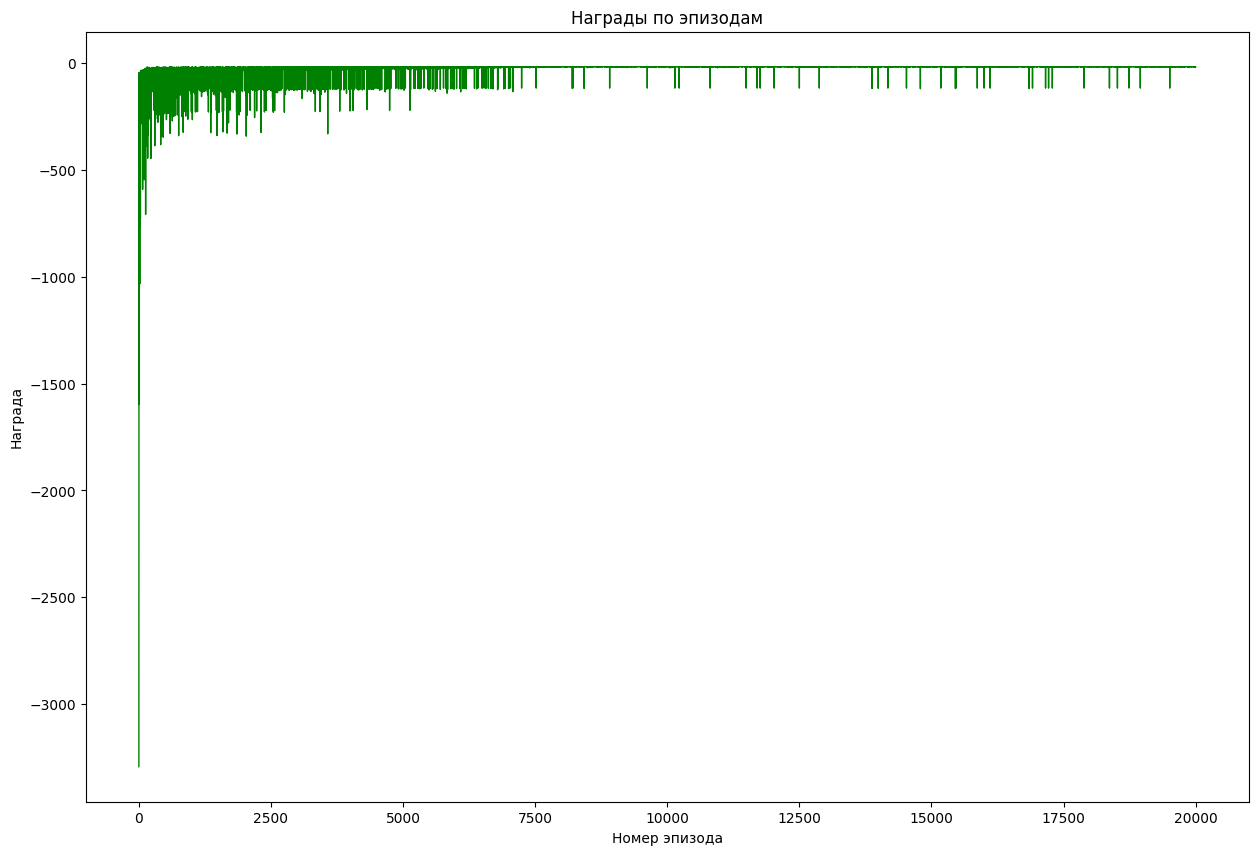

Action Space: Discrete(4)
Observation Space: Discrete(48)
Max Episode Steps: None
Nondeterministic: False
Reward Range: (-inf, inf)
Reward Threshold: None
Moviepy - Building video /content/video/CliffWalking-v0/e7279c2e-b441-437b-b8a6-c5552709832a/rl-video-step-0.mp4.
Moviepy - Writing video /content/video/CliffWalking-v0/e7279c2e-b441-437b-b8a6-c5552709832a/rl-video-step-0.mp4



Moviepy - Done !
Moviepy - video ready /content/video/CliffWalking-v0/e7279c2e-b441-437b-b8a6-c5552709832a/rl-video-step-0.mp4


In [ ]:
env = gym.make('CliffWalking-v0')
agent = SARSA_Agent(env)
agent.learn()
agent.print_q()
agent.draw_episodes_reward()
play_agent(agent)

## Модель Q-LEARNING

Реализует полный цикл обучения и тестирования агента с использованием алгоритма Q-Learning

100%|██████████| 20000/20000 [00:15<00:00, 1292.65it/s]


Вывод Q-матрицы для алгоритма  Q-обучение
[[ -12.46582079  -12.31087749  -12.31097548  -12.61142695]
 [ -12.196814    -11.54856455  -11.54857318  -12.53382469]
 [ -11.45398425  -10.7641547   -10.76415544  -11.94506525]
 [ -10.72178457   -9.9634312    -9.96343121  -11.4932044 ]
 [  -9.94443977   -9.14635949   -9.1463595   -10.59257514]
 [  -9.10652806   -8.31261186   -8.31261186   -9.95188676]
 [  -8.29412186   -7.46184886   -7.46184886   -9.13026862]
 [  -7.45668199   -6.59372334   -6.59372334   -8.27188179]
 [  -6.55136999   -5.70788096   -5.70788096   -7.4309189 ]
 [  -5.6948827    -4.80396016   -4.80396016   -6.55010311]
 [  -4.79986691   -3.881592     -3.881592     -5.68590873]
 [  -3.82233241   -3.8576014    -2.9404       -4.71952531]
 [ -13.05713806  -11.54888054  -11.54888054  -12.31757025]
 [ -12.31658878  -10.76416381  -10.76416381  -12.31789924]
 [ -11.54885789   -9.96343246   -9.96343246  -11.54888049]
 [ -10.76415759   -9.14635966   -9.14635966  -10.76416358]
 [  -9.9634316

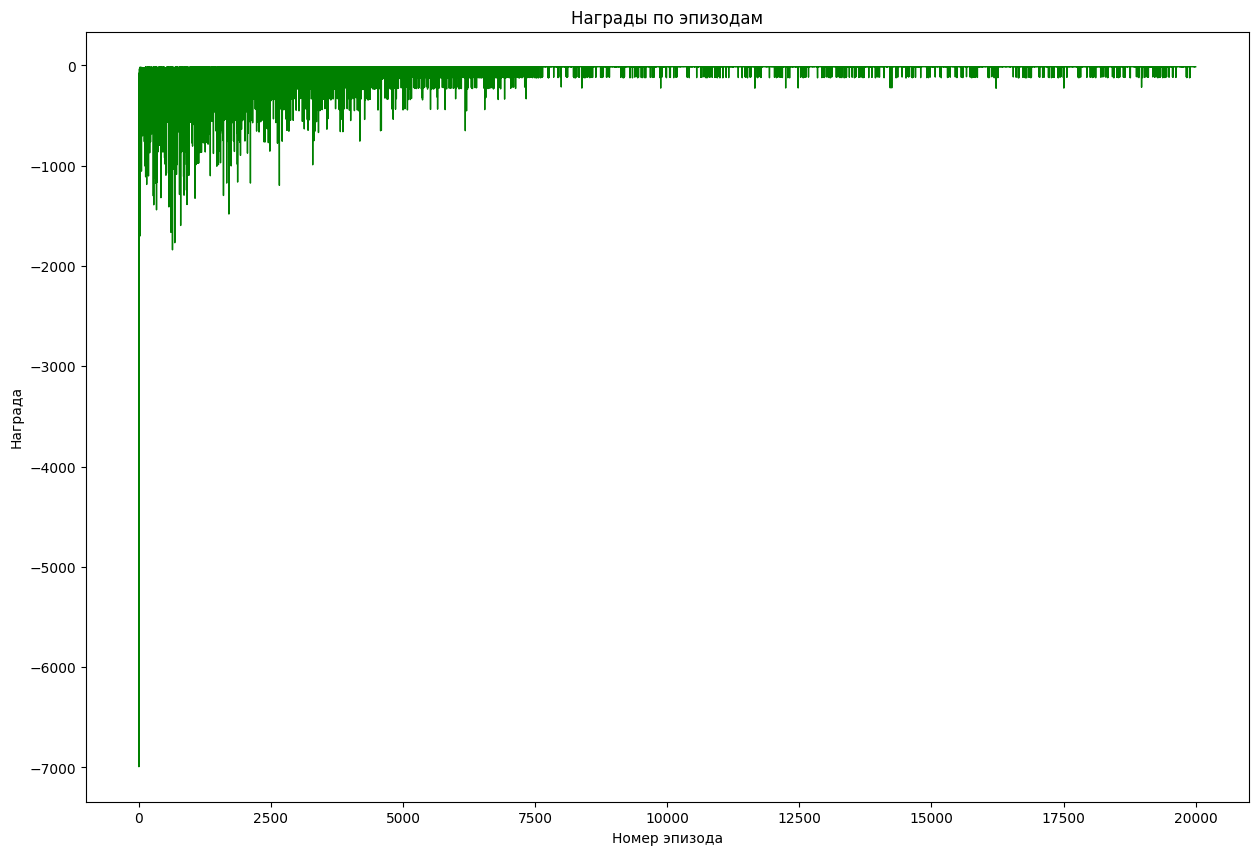

Action Space: Discrete(4)
Observation Space: Discrete(48)
Max Episode Steps: None
Nondeterministic: False
Reward Range: (-inf, inf)
Reward Threshold: None
Moviepy - Building video /content/video/CliffWalking-v0/92aaf38a-f22c-4763-ac41-764be2aae698/rl-video-step-0.mp4.
Moviepy - Writing video /content/video/CliffWalking-v0/92aaf38a-f22c-4763-ac41-764be2aae698/rl-video-step-0.mp4



Moviepy - Done !
Moviepy - video ready /content/video/CliffWalking-v0/92aaf38a-f22c-4763-ac41-764be2aae698/rl-video-step-0.mp4


In [ ]:
env = gym.make('CliffWalking-v0')
agent = QLearning_Agent(env)
agent.learn()
agent.print_q()
agent.draw_episodes_reward()
play_agent(agent)

## Модель DQ-LEARNING

Реализует полный цикл обучения и тестирования агента с использованием алгоритма Double Q-Learning

100%|██████████| 20000/20000 [00:14<00:00, 1341.73it/s]


Вывод Q-матриц для алгоритма  Двойное Q-обучение
Q1
[[ -20.91307461  -20.29270388  -12.37573159  -19.15727413]
 [ -21.95994696  -19.36749902  -11.70414129  -21.28503949]
 [ -18.86812001  -19.83179315  -10.79190077  -20.68895778]
 [ -16.63780439  -18.63154759   -9.96387188  -18.28683229]
 [ -16.13713997   -9.14660468  -13.70436745  -17.59609997]
 [  -9.86775017   -8.31261196   -8.89495256  -12.02957105]
 [  -8.78416347   -7.46184887   -7.67239998   -9.38964291]
 [  -7.71572266   -6.59372334   -6.8546312    -8.64005518]
 [  -6.62649124   -5.92884553   -5.70788096   -7.57979822]
 [  -7.53209769   -4.80396499   -5.81430608   -7.56478336]
 [  -5.1570087    -3.88159211   -8.85206695   -6.52550436]
 [  -4.01936122   -4.05730335   -2.9404       -5.05599198]
 [ -13.61594228  -11.87093321  -11.54888054  -12.39804229]
 [ -13.99020059  -10.76416381  -11.10410052  -12.42535999]
 [ -11.62028167   -9.96343246   -9.97404728  -11.55552052]
 [ -10.77077873   -9.14635966   -9.14676824  -10.76558188]
 [  

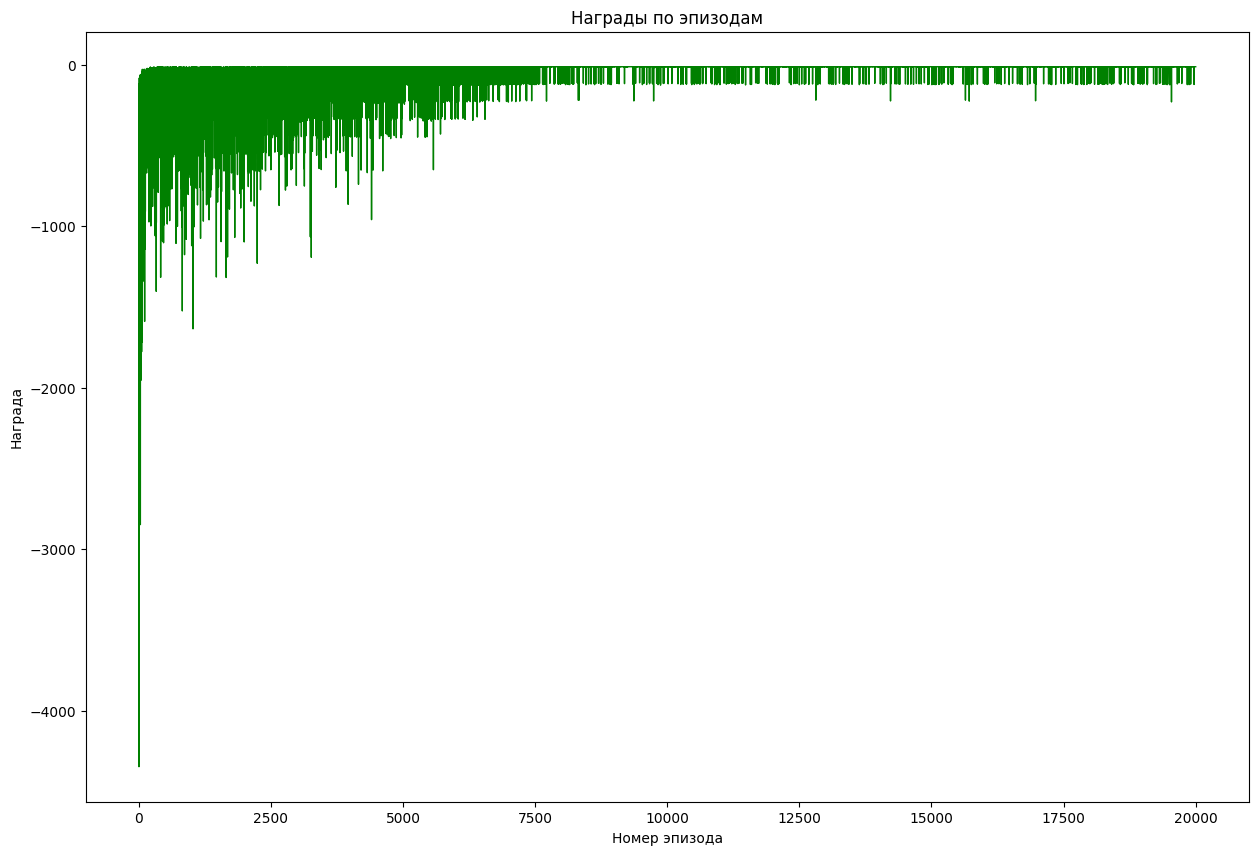

Action Space: Discrete(4)
Observation Space: Discrete(48)
Max Episode Steps: None
Nondeterministic: False
Reward Range: (-inf, inf)
Reward Threshold: None
Moviepy - Building video /content/video/CliffWalking-v0/ee96462f-1319-4aa0-962c-92443c13b66b/rl-video-step-0.mp4.
Moviepy - Writing video /content/video/CliffWalking-v0/ee96462f-1319-4aa0-962c-92443c13b66b/rl-video-step-0.mp4



Moviepy - Done !
Moviepy - video ready /content/video/CliffWalking-v0/ee96462f-1319-4aa0-962c-92443c13b66b/rl-video-step-0.mp4


In [ ]:
env = gym.make('CliffWalking-v0')
agent = DoubleQLearning_Agent(env)
agent.learn()
agent.print_q()
agent.draw_episodes_reward()
play_agent(agent)

##Вывод
В ходе выполнения лабораторной работы ознакомился с тремя алгоритмами обучения с подкреплением: SARSA, Q-Learning и Double Q-Learning.

Реализовал эти алгоритмы в коде и провели их сравнение на задаче "обрыва" (CliffWalking-v0).
Наблюдал, как агенты, обученные с помощью каждого из алгоритмов, справляются с задачей.
Сравнил эффективность обучения, изучив графики накопленной награды за каждый эпизод для каждого алгоритма.
В итоге получил практическое представление о работе алгоритмов обучения с подкреплением, их отличиях и  о том, как они справляются с задачей "обрыва".